## TO DO LIST

May 7th
- Add the 1st and 2nd half analysis to self intersection (load the experiment/.mat file here in the notebook for the 1st and 2nd half notebooks)
- Replace the self intersection analysis file with the one where the slow parts of the trajectory have been removed (do it for the whole analysis, and also for the 1st and 2nd half analysis)
- Add the remove_slow_parts function to the curvature analysis (whole trajectory, 1st and 2nd half too)

April 25th meeting
- curvature is not a good measure, because longer trajectories tend to have lower curvature (since there's more balistic behavior and less foraging behavior, so less sharp turns)
- in very short trajectories, a single sharp turn can make the average curvature very high, because a sharp turn makes the velocity go to zero, and that makes K -> infinity
- so my hypothesis is that total travelled distance correlates with inverse curvature (i.e., longer distance have less curvature)
- total travelled distance has to be divided by the food-entrance distance, so that all trajectories are normalized by the optimal behavior for each entrance
- one way to really know how error goes with the distance would be to have targets placed at different distances from the entrance (with fixed entrance): farther targets would have farther errors (i.e., longer times or longer distances in the trial)

In [1]:
import os
import copy
import numpy
import modules.io as io
import modules.plot_func as pltt
import modules.traj_analysis as tran
import modules.helper_func_class as misc
import modules.process_mouse_trials_lib as plib
import matplotlib.pyplot as plt
import scipy.stats
import warnings

warnings.filterwarnings('ignore')
#import matplotlib.image as mpimg


"""

THE SUFFIXES IN THE VARIABLE NAMES

*** p1 suffix -> 2-target probe 1 (only target 1 is trained)

*** p2 suffix -> 2-target probe 2 (both targets are trained)

"""

mouse_traj_dir = r'./experiments/two_target_no_cues/mouse_*'

output_dir = 'figs/paper/2targets/all_trials'
try:
    os.makedirs(output_dir)
except FileExistsError:
    pass

color_p2 = numpy.array((65, 102, 216, 255))/255
color_p3 = pltt.get_gradient(2,'yellow')[::-1][0]
color_l1 = numpy.array((224, 53, 53, 255))/255

color_lightblue   = numpy.array((65, 102, 216, 255))/255 #pltt.get_gradient(5,'blue2')[2] #numpy.array((65, 102, 216, 255))/255
color_darkblue    = numpy.append(pltt.get_gradient(2,'blue')[1],1.0) #numpy.array((224, 53, 53, 255))/255
color_darkyellow  = numpy.append(pltt.get_gradient(2,'yellow')[::-1][0],1.0)
color_lightyellow = numpy.append(pltt.get_gradient(10,'yellow')[2],1.0)
color_lightred    = pltt.get_gradient(2,'red')[0] #numpy.array((65, 102, 216, 255))/255 #pltt.get_gradient(5,'blue2')[2] #numpy.array((65, 102, 216, 255))/255
color_darkred     = pltt.get_gradient(2,'red')[1] #numpy.array((224, 53, 53, 255))/255
color_gray        = numpy.append(0.7*numpy.ones(3),1.0)
color_red         = numpy.array((255, 66, 66,255))/255
color_blue        = numpy.array(( 10, 30,211,255))/255
color_orange      = pltt.get_gradient(10,'orange')[0]

SMALL_FONTSIZE  = 12
MEDIUM_FONTSIZE = 14
LARGE_FONTSIZE  = 16
plt.rc('font',        size=SMALL_FONTSIZE )  # controls default text sizes
plt.rc('axes',   titlesize=SMALL_FONTSIZE )  # fontsize of the axes title
plt.rc('axes',   labelsize=MEDIUM_FONTSIZE) # fontsize of the x and y labels
plt.rc('xtick',  labelsize=SMALL_FONTSIZE ) # fontsize of the tick labels
plt.rc('ytick',  labelsize=SMALL_FONTSIZE ) # fontsize of the tick labels
plt.rc('legend',  fontsize=SMALL_FONTSIZE ) # legend fontsize
plt.rc('figure', titlesize=LARGE_FONTSIZE ) # fontsize of the figure title


FIGSIZE_1PANEL = numpy.array((4,3),dtype=float)
AX_POS_1PANEL  = numpy.array( [ 0.125, 0.125, 0.9, 0.88 ] ) # [xmin,ymin,width,heigh]
AX_POS_2PANELS = numpy.array([   AX_POS_1PANEL/2.0,
                               [ 1.5*AX_POS_1PANEL[0]+AX_POS_1PANEL[2]/2,AX_POS_1PANEL[1]/2,AX_POS_1PANEL[2]/2-0.5*AX_POS_1PANEL[0],AX_POS_1PANEL[3]/2 ] ])


# linear regression aux function
linreg_lin_func = lambda x,lr: lr.intercept + lr.slope * x
linreg_pl_func  = lambda x,lr: numpy.exp(lr.intercept + numpy.log(x)*lr.slope)
linreg_exp_func = lambda x,lr: numpy.exp(lr.intercept + x*lr.slope)

# t-test aux function
p_significant = 0.05
q_FDR         = 0.05 # FDR-level for thresholding p_values correcting for false-discovery rate in multiple comparisons
check_significance = lambda ttest_res: ttest_res.pvalue < p_significant


# loads experiment MAT files from file path according to the parameters
n_trials_l1    = 18
nmax_trials_l2 = 26
n_trials_p2    = 1

# loading all training trials for target 1

time_delay_after_food = 1.5 # sec
hole_horizon          = 10.0 # cm

# all_trials_l1[k][m] -> trial k of mouse m
all_trials_l1 = io.load_trial_file(mouse_traj_dir, load_only_training_sessions_relative_target=True, fix_nan=True,group_by='trial',return_group_by_keys=False,remove_after_food=False,max_trial_number=n_trials_l1)
all_trials_l1 = tran.remove_path_after_food(all_trials_l1,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)

# loading all training trials for target 2 (after target 1)
# all_trials_l2[k][m] -> trial k of mouse m
all_trials_l2 = io.load_trial_file(mouse_traj_dir, load_only_training_sessions_relative_target=True, fix_nan=True,group_by='trial',return_group_by_keys=False,remove_after_food=False,max_trial_number=nmax_trials_l2)
all_trials_l2 = io.select_numeric_trials(all_trials_l2,trial0=n_trials_l1+1,trial1=nmax_trials_l2,get_trial_number_func=lambda tr: int(tr[0].trial))
all_trials_l2 = tran.remove_path_after_food(all_trials_l2,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)


all_trials_p2_complete = io.load_trial_file(mouse_traj_dir,file_name_expr='mpos_*Probe2_*',align_to_top=True,fix_nan=True,sort_by_trial=True,return_group_by_keys=False,remove_after_food=False)
all_trials_p2          = tran.keep_path_between_targets(all_trials_p2_complete,return_t_in_targets=False,hole_horizon=hole_horizon,time_delay_after_food=2.0*time_delay_after_food,copy_tracks=True)


all_trials_l1_rot = plib.rotate_trial_file(copy.deepcopy(all_trials_l1),(0,1),True)
all_trials_l2_rot = plib.rotate_trial_file(copy.deepcopy(all_trials_l2),(0,1),True)


mouse_number_l1 = numpy.array([ int(tr.mouse_number) for tr in all_trials_l1[0] ])


d_food_baseline_l1 = numpy.linalg.norm(all_trials_l1[0][0].r_target-all_trials_l1[0][0].r_start)
d_food_baseline_l2 = numpy.linalg.norm(all_trials_l2[0][0].r_target-all_trials_l2[0][0].r_start)

d_food_control_p2  = None
d_food_control_p3  = None
n_holes_control_p2 = None
n_holes_control_p3 = None

save_output_figures = True


Minimum distance to the second target

Minimum distance to target B (while training target A)

 *** T-Test between first and last trials

     Distance to B            (1 vs. 18)(*):: T = -4.6588942     p = 0.00067253974
     Distance to Random Point (1 vs. 18)(*):: T = -5.1126816     p = 0.00023334938
 

-
Minimum distance to target A (while training target B)

 *** T-Test between first and last trials

     Distance to A            (1 vs. 8)(*):: T = -5.2217137     p = 0.0012223592
     Distance to Random Point (1 vs. 8)(*):: T = -7.0867403     p = 9.78621e-05
 



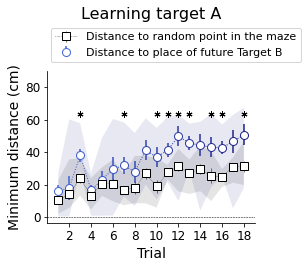

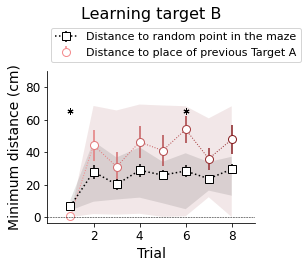

In [15]:
#import sys
#if 'modules.traj_analysis' in sys.modules.keys():
#    del sys.modules['modules.traj_analysis']
#if tran:
#    del tran
#import modules.traj_analysis as tran


dmin_l1     = tran.find_min_distance_to_alt_target(all_trials_l1_rot)
dmin_l2     = tran.find_min_distance_to_alt_target(all_trials_l2_rot)
dmin_l1_rnd = tran.find_min_distance_to_random_point(all_trials_l1_rot,n_points=50)
dmin_l2_rnd = tran.find_min_distance_to_random_point(all_trials_l2_rot,n_points=50)

n_trials_l1 = len(all_trials_l1_rot)
n_trials_l2 = len(all_trials_l2_rot)


#######
####### t-test
#######

p_significant      = 0.05
q_FDR              = 0.05
check_significance = lambda ttest_res: ttest_res.pvalue < p_significant

dmin_Z_l1,dmin_Z_l1_rnd  = misc.zscore_to_control(  misc.asarray_nanfill(dmin_l1)[:n_trials_l1,:], misc.asarray_nanfill(dmin_l1_rnd)[:n_trials_l1,:]   , axis=1)
dmin_Z_l2,dmin_Z_l2_rnd  = misc.zscore_to_control(  misc.asarray_nanfill(dmin_l2)[:n_trials_l2,:], misc.asarray_nanfill(dmin_l2_rnd)[:n_trials_l2,:]   , axis=1)

# comparing each trial of actual distance vs. random distance
dmin_ttest_trials_l1    = scipy.stats.ttest_ind(dmin_Z_l1,dmin_Z_l1_rnd,axis=1,equal_var=False,nan_policy='omit',alternative='two-sided')
k_significant_trials_l1 =   misc.check_p_values(dmin_ttest_trials_l1,p_significant,q_FDR) # index of significant trials
dmin_ttest_trials_l2    = scipy.stats.ttest_ind(dmin_Z_l2,dmin_Z_l2_rnd,axis=1,equal_var=False,nan_policy='omit',alternative='two-sided')
k_significant_trials_l2 =   misc.check_p_values(dmin_ttest_trials_l2,p_significant,q_FDR) # index of significant trials

# comparing first with last trial
dmin_ttest_first_last_l1     = scipy.stats.ttest_ind(    dmin_l1[0],    dmin_l1[n_trials_l1-1],equal_var=False,nan_policy='omit',alternative='two-sided')
dmin_ttest_first_last_l1_rnd = scipy.stats.ttest_ind(dmin_l1_rnd[0],dmin_l1_rnd[n_trials_l1-1],equal_var=False,nan_policy='omit',alternative='two-sided')
dmin_ttest_first_last_l2     = scipy.stats.ttest_ind(    dmin_l2[0],    dmin_l2[n_trials_l2-1],equal_var=False,nan_policy='omit',alternative='two-sided')
dmin_ttest_first_last_l2_rnd = scipy.stats.ttest_ind(dmin_l2_rnd[0],dmin_l2_rnd[n_trials_l2-1],equal_var=False,nan_policy='omit',alternative='two-sided')


ttest_result  = 'Minimum distance to target B (while training target A)\n\n'
ttest_result += ' *** T-Test between first and last trials' + '\n\n'
ttest_result += f'     Distance to B            (1 vs. {n_trials_l1})' + '{2:s}:: T = {0:.8g}     p = {1:.8g}'.format(    dmin_ttest_first_last_l1.statistic,    dmin_ttest_first_last_l1.pvalue,'(*)' if check_significance(    dmin_ttest_first_last_l1) else '   ') + '\n'
ttest_result += f'     Distance to Random Point (1 vs. {n_trials_l1})' + '{2:s}:: T = {0:.8g}     p = {1:.8g}'.format(dmin_ttest_first_last_l1_rnd.statistic,dmin_ttest_first_last_l1_rnd.pvalue,'(*)' if check_significance(dmin_ttest_first_last_l1_rnd) else '   ') + '\n'
ttest_result += ' ' + '\n'
print(ttest_result)
print('-')
ttest_result  = 'Minimum distance to target A (while training target B)\n\n'
ttest_result += ' *** T-Test between first and last trials' + '\n\n'
ttest_result += f'     Distance to A            (1 vs. {n_trials_l2})' + '{2:s}:: T = {0:.8g}     p = {1:.8g}'.format(    dmin_ttest_first_last_l2.statistic,    dmin_ttest_first_last_l2.pvalue,'(*)' if check_significance(    dmin_ttest_first_last_l2) else '   ') + '\n'
ttest_result += f'     Distance to Random Point (1 vs. {n_trials_l2})' + '{2:s}:: T = {0:.8g}     p = {1:.8g}'.format(dmin_ttest_first_last_l2_rnd.statistic,dmin_ttest_first_last_l2_rnd.pvalue,'(*)' if check_significance(dmin_ttest_first_last_l2_rnd) else '   ') + '\n'
ttest_result += ' ' + '\n'
print(ttest_result)



dmin_mmean_sd_err_l1     = numpy.array(misc.mean_std_err_minmax(misc.asarray_nanfill(dmin_l1    ),axis=1)).T
dmin_mmean_sd_err_l2     = numpy.array(misc.mean_std_err_minmax(misc.asarray_nanfill(dmin_l2    ),axis=1)).T
dmin_mmean_sd_err_l1_rnd = numpy.array(misc.mean_std_err_minmax(misc.asarray_nanfill(dmin_l1_rnd),axis=1)).T
dmin_mmean_sd_err_l2_rnd = numpy.array(misc.mean_std_err_minmax(misc.asarray_nanfill(dmin_l2_rnd),axis=1)).T

fh,ax = plt.subplots(nrows=1,ncols=1,sharex=False,sharey=False,figsize=FIGSIZE_1PANEL)
ax.set_position(list(AX_POS_1PANEL[:2])+list(AX_POS_1PANEL[2:]*0.8))

pltt.plot_errorfill(numpy.arange(n_trials_l1)+1,dmin_mmean_sd_err_l1[:n_trials_l1,0],[dmin_mmean_sd_err_l1[:n_trials_l1,-2],dmin_mmean_sd_err_l1[:n_trials_l1,-1]],fmt=':',color=color_darkblue,alpha=0,ax=ax,markersize=8,absolute_err=True,alpha_fill=0.1)
pltt.plot_errorfill(numpy.arange(n_trials_l1)+1,dmin_mmean_sd_err_l1_rnd[:n_trials_l1,0],[dmin_mmean_sd_err_l1_rnd[:n_trials_l1,-2],dmin_mmean_sd_err_l1_rnd[:n_trials_l1,-1]],fmt=':',color='k',alpha=0,ax=ax,markersize=8,absolute_err=True,alpha_fill=0.1)
pltt.plot_gradient_line(numpy.array((numpy.arange(n_trials_l1)+1,dmin_mmean_sd_err_l1[:n_trials_l1,0])).T,cmap=pltt.get_gradient_between(color_lightblue,color_darkblue),linewidth=1, alpha=1.0, ax=ax, linestyle=':')
pltt.plot_gradient_errorbar(ax,numpy.arange(n_trials_l1)+1, dmin_mmean_sd_err_l1[:n_trials_l1,0],dmin_mmean_sd_err_l1[:n_trials_l1,2],cmap=pltt.get_gradient_between(color_lightblue,color_darkblue),fmt='o',markersize=8,markerfacecolor='w',label='Distance to place of future Target B')
ax.errorbar(numpy.arange(n_trials_l1)+1, dmin_mmean_sd_err_l1_rnd[:n_trials_l1,0],dmin_mmean_sd_err_l1_rnd[:n_trials_l1,2],color='k',fmt=':s',linewidth=0.5,markersize=8,markerfacecolor='w',label='Distance to random point in the maze')
y0_asterisk = ax.get_ylim()[0] + 0.9*numpy.diff(ax.get_ylim())[0]
ax.plot((numpy.arange(n_trials_l1)+1)[k_significant_trials_l1], y0_asterisk*numpy.ones(n_trials_l1)[k_significant_trials_l1], markersize=6, marker=(6,2), linestyle='none', color='k' )
pltt.plot_horizontal_lines(0,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=0,xMax=n_trials_l1+1)
#ax.set_yscale('log')
ax.set_xticks(numpy.arange(n_trials_l1+1)[2::2])
ax.set_xlim(0,n_trials_l1+1)
ax.set_ylim(top=90)
#ax.legend(loc='upper right', bbox_to_anchor=(1.02, 1),fontsize=11)
pltt._add_legend_custom_order_labels(ax,[1,0],loc='lower left', bbox_to_anchor=(-0.01, 1.02),fontsize=11)
ax.set_xlabel('Trial')
ax.set_ylabel('Minimum distance (cm)')#('Distance walked\nper target distance')
ax.set_title('Learning target A',fontsize=LARGE_FONTSIZE,y=1.3)
pltt.set_box_axis(ax,False)
if save_output_figures:
    plt.savefig(  f'{output_dir}/2target_learningA_dist_to_B.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')


fh,ax = plt.subplots(nrows=1,ncols=1,sharex=False,sharey=False,figsize=FIGSIZE_1PANEL)
ax.set_position(list(AX_POS_1PANEL[:2])+list(AX_POS_1PANEL[2:]*0.8))

pltt.plot_errorfill(numpy.arange(n_trials_l2)+1,dmin_mmean_sd_err_l2[:n_trials_l2,0],[dmin_mmean_sd_err_l2[:n_trials_l2,-2],dmin_mmean_sd_err_l2[:n_trials_l2,-1]],fmt=':',color=color_darkred,alpha=0,ax=ax,markersize=8,absolute_err=True,alpha_fill=0.1)
pltt.plot_errorfill(numpy.arange(n_trials_l2)+1,dmin_mmean_sd_err_l2_rnd[:n_trials_l2,0],[dmin_mmean_sd_err_l2_rnd[:n_trials_l2,-2],dmin_mmean_sd_err_l2_rnd[:n_trials_l2,-1]],fmt=':',color='k',alpha=0,ax=ax,markersize=8,absolute_err=True,alpha_fill=0.1)
pltt.plot_gradient_line(numpy.array((numpy.arange(n_trials_l2)+1,dmin_mmean_sd_err_l2[:n_trials_l2,0])).T,cmap=pltt.get_gradient_between(color_lightred,color_darkred),linewidth=1, alpha=1.0, ax=ax, linestyle=':')
pltt.plot_gradient_errorbar(ax,numpy.arange(n_trials_l2)+1, dmin_mmean_sd_err_l2[:n_trials_l2,0],dmin_mmean_sd_err_l2[:n_trials_l2,2],cmap=pltt.get_gradient_between(color_lightred,color_darkred),fmt='o',markersize=8,markerfacecolor='w',label='Distance to place of previous Target A')
ax.errorbar(numpy.arange(n_trials_l2)+1, dmin_mmean_sd_err_l2_rnd[:n_trials_l2,0],dmin_mmean_sd_err_l2_rnd[:n_trials_l2,2],color='k',fmt=':s',markersize=8,markerfacecolor='w',label='Distance to random point in the maze')
y0_asterisk = ax.get_ylim()[0] + 0.9*numpy.diff(ax.get_ylim())[0]
ax.plot((numpy.arange(n_trials_l2)+1)[k_significant_trials_l2], y0_asterisk*numpy.ones(n_trials_l2)[k_significant_trials_l2], markersize=6, marker=(6,2), linestyle='none', color='k' )
pltt.plot_horizontal_lines(0,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=0,xMax=n_trials_l2+1)
#ax.set_yscale('log')
ax.set_xticks(numpy.arange(n_trials_l2+1)[2::2])
ax.set_xlim(0,n_trials_l2+1)
ax.set_ylim(top=90)
#ax.legend(loc='upper right', bbox_to_anchor=(1.02, 1),fontsize=11)
pltt._add_legend_custom_order_labels(ax,[1,0],loc='lower left', bbox_to_anchor=(-0.01, 1.02),fontsize=11)
ax.set_xlabel('Trial')
ax.set_ylabel('Minimum distance (cm)')#('Distance walked\nper target distance')
ax.set_title('Learning target B',fontsize=LARGE_FONTSIZE,y=1.3)
pltt.set_box_axis(ax,False)
if save_output_figures:
    plt.savefig(  f'{output_dir}/2target_learningB_dist_to_A.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

Learning A -- all trials: 1 to 4

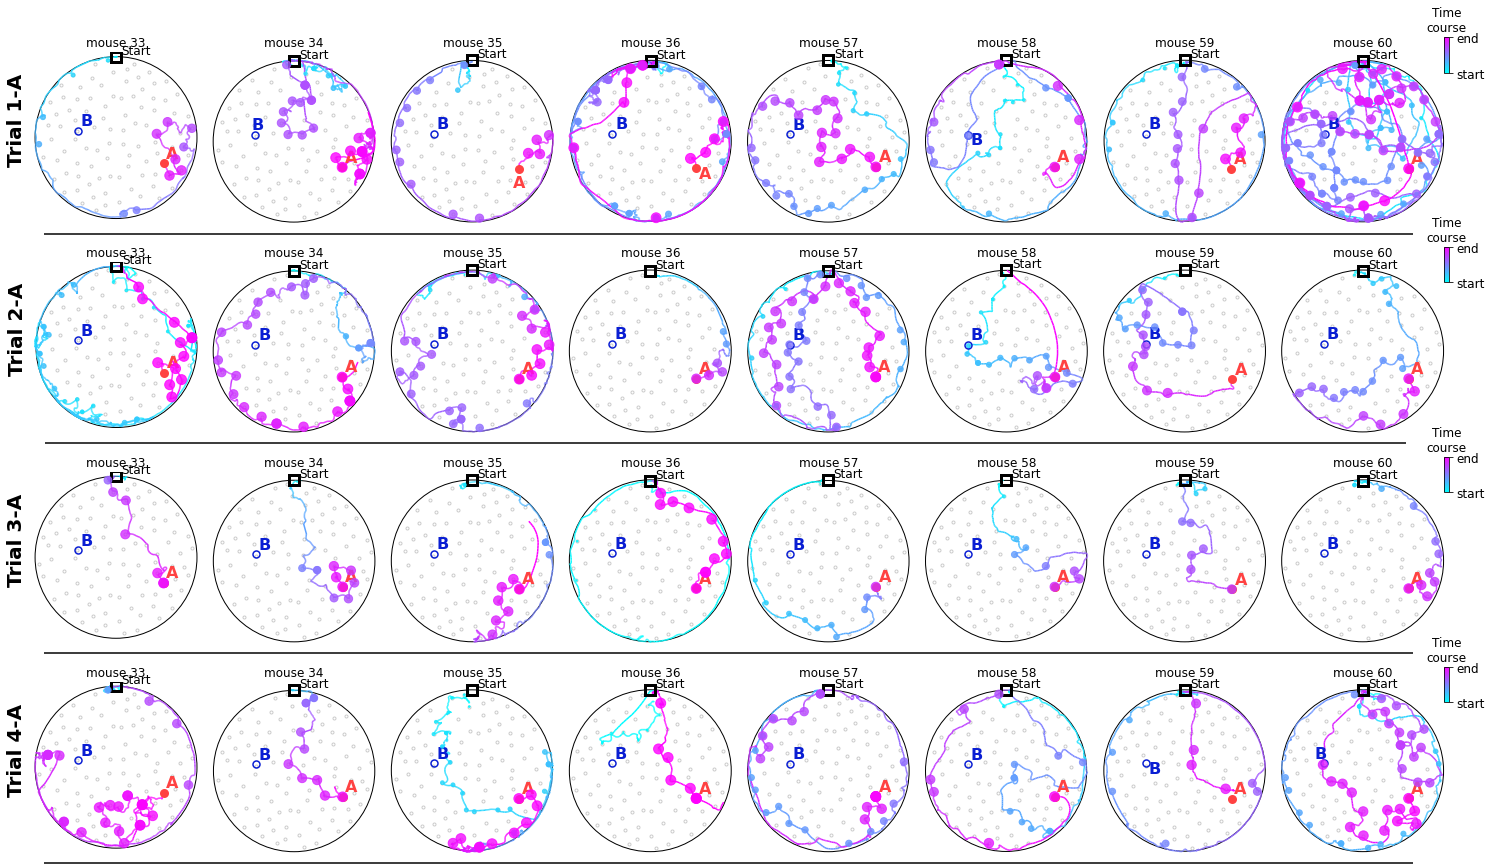

In [37]:
#import sys
#if 'modules.traj_analysis' in sys.modules.keys():
#    del sys.modules['modules.traj_analysis']
#if tran:
#    del tran
#import modules.traj_analysis as tran

import sys
if 'modules.plot_func' in sys.modules.keys():
    del sys.modules['modules.plot_func']
if pltt:
    del pltt
import modules.plot_func as pltt

trim_trajectories  = True
traj_alpha         = 0.5

hole_horizon          = 10.0 # cm
time_delay_after_food = 1.0 # sec
start_vec_align       = (0,1)

ignore_entrance_positions   = False
normalize_by                = 'max'
hole_horizon_hole_check     = 3.0 #cm
threshold_method            = 'ampv'
velocity_amplitude_fraction = 0.2
use_velocity_minima         = True
velocity_min_prominence     = 5.0 # cm/s

#if trim_trajectories:
#    tracks_to_plot = []
#    for tr,tr_trim in zip(all_trials_p2_complete,all_trials_p2):
#        t0 = 0.0 # seconds
#        if (int(tr.mouse_number) == 35):
#            t0 = 35.0 # the mouse doesn't move in the first 35 seconds
#        if (int(tr.mouse_number) == 34):
#            t0 = 20.0 # the mouse doesn't move in the first 35 seconds
#        tr_new = tran.slice_track_by_time(tr,t0=t0,t1=tr_trim.time[-1]+1,copy_track=True)
#        tr_new.time -= tr_new.time[0]
#        tracks_to_plot.append(tr_new)
#else:
#    tracks_to_plot = copy.deepcopy(all_trials_p2_complete)

first_trial       = 1
last_trial        = 4
tracks_to_plot    = list(misc.flatten_list(copy.deepcopy(all_trials_l1_rot[(first_trial-1):last_trial]),only_lists=True))
nrows_ncols_tuple = ((last_trial-first_trial+1),8)



all_trials = plib.rotate_trial_file(tracks_to_plot,start_vec_align,True)
k_slow,t_slow,r_slow,v_th = misc.unpack_list_of_tuples([ tran.find_slowing_down_close_to_hole(tr,hole_horizon_hole_check,threshold_method=threshold_method,gamma=velocity_amplitude_fraction,
                                                                                                 return_pos_from='hole',ignore_entrance_positions=ignore_entrance_positions,
                                                                                                 use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for tr in all_trials ])


color_red    = numpy.array((255, 66, 66,255))/255
color_blue   = numpy.array(( 10, 30,211,255))/255
color_orange = pltt.get_gradient(10,'orange')[0]
ax,lines,panel_ind=pltt.plot_all_tracks_2targets(all_trials,hole_horizon,time_delay_after_food,
                                       traj1Args=dict(color                  = plt.get_cmap('cool'),
                                                      line_gradient_variable = 'time',
                                                      alpha                  = traj_alpha,
                                                      show_colorbar=False,
                                                      startArgs     = dict(marker='s',markeredgewidth=3  ,markersize=10,color='k'       ,fillstyle='none',label='Start',labelArgs=dict(fontsize=12,va='bottom',ha='left',color='k',pad=(4,0)  ) ),
                                                      targetArgs    = dict(marker='o',markeredgewidth=3  ,markersize= 6,color=color_red ,fillstyle='full',label='A'    ,labelArgs=dict(fontsize=16,va='bottom',ha='left', fontweight='bold',color=color_red ,pad=(2,2))),
                                                      targetAltArgs = dict(marker='o',markeredgewidth=1.5,markersize= 7,color=color_blue,fillstyle='none',label='B'    ,labelArgs=dict(fontsize=16,va='bottom',ha='left', fontweight='bold',color=color_blue,pad=(2,2)))),
                                       traj2Args=dict(color=(0,0,0),alpha=traj_alpha),start_align_vector=start_vec_align,
                                       trim_trajectories=False,return_panel_ind=True,show_arena_holes=True,
                                       probe_title='',fig_size=(30,22),nrows_ncols_tuple=nrows_ncols_tuple,show_probetitle=False,fix_mouse_order_in_probe=False)
text_h = [tt for tt in misc.flatten_list(lines) if (('text' in str(type(tt))) and (tt.get_text() != 'Start'))]
text_h[11].set(va='top')   # A,i=0,j=3
text_h[3].set(ha='center') # A,i=1,j=1
text_h[-3].set(va='top')   # A,i=1,j=2
text_h[-1].set(ha='right') # A,i=1,j=3
text_h[6].set(va='top')    # B,i=0,j=1
text_h[4].set(va='top',ha='center',position=numpy.array(text_h[4].get_position())-numpy.array((2,6)))    # B,i=0,j=0


ax = pltt.tight_arena_panels(ax,adjust_title_position=False,dy_amid_panels=0.02)

cax = []
for k,(ind,r,tr) in enumerate(zip(k_slow,r_slow,tracks_to_plot)):
    t_seq = tr.time[ind]/tr.time[-1]
    i,j = numpy.unravel_index(k,nrows_ncols_tuple)
    pltt.plot_trajectory_points(r,ax=ax[i,j],use_scatter=True,s=1e2*t_seq,marker='o',c=plt.get_cmap('cool')(t_seq),zorder=10000,alpha=0.8)
    if j == 0:
        ax[i,j].text(-75,-20,'Trial %d-A'%plib.trial_to_number(tr.trial),rotation=90,va='bottom',ha='center',fontsize=20,fontweight='bold')
        x_lim = ax[i,j].get_xlim()
        y_lim = ax[i,j].get_xlim()
        lh = pltt.plot_horizontal_lines(-70,ax[i,j],xMin=-55,xMax=120*8,color='k',linewidth=1.5,linestyle='-')
        lh.set_clip_on(False)
        ax[i,j].set_xlim(x_lim)
        ax[i,j].set_ylim(y_lim)
    if j == (nrows_ncols_tuple[1]-1):
        cax.append(pltt._add_colorbar(ax[i,j],'cool',w_fraction_of_ax=0.03,h_fraction_of_ax=0.2,p0=(1.01,1.1),minmax_tick_labels=('start','end'),title='Time\ncourse',titleArgs=dict(color='k',fontsize=12),ticklabelsArgs=dict(color='k')))


if save_output_figures:
    detection_label = 'vmin' if use_velocity_minima else 'slowdown'
    plt.savefig(  f'{output_dir}/twotargets_trajectories_ALL_TRIALS_LEARNING_A_{first_trial}-{last_trial}_{detection_label}.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')



plt.show()

Learning A -- all trials: 5 to 8

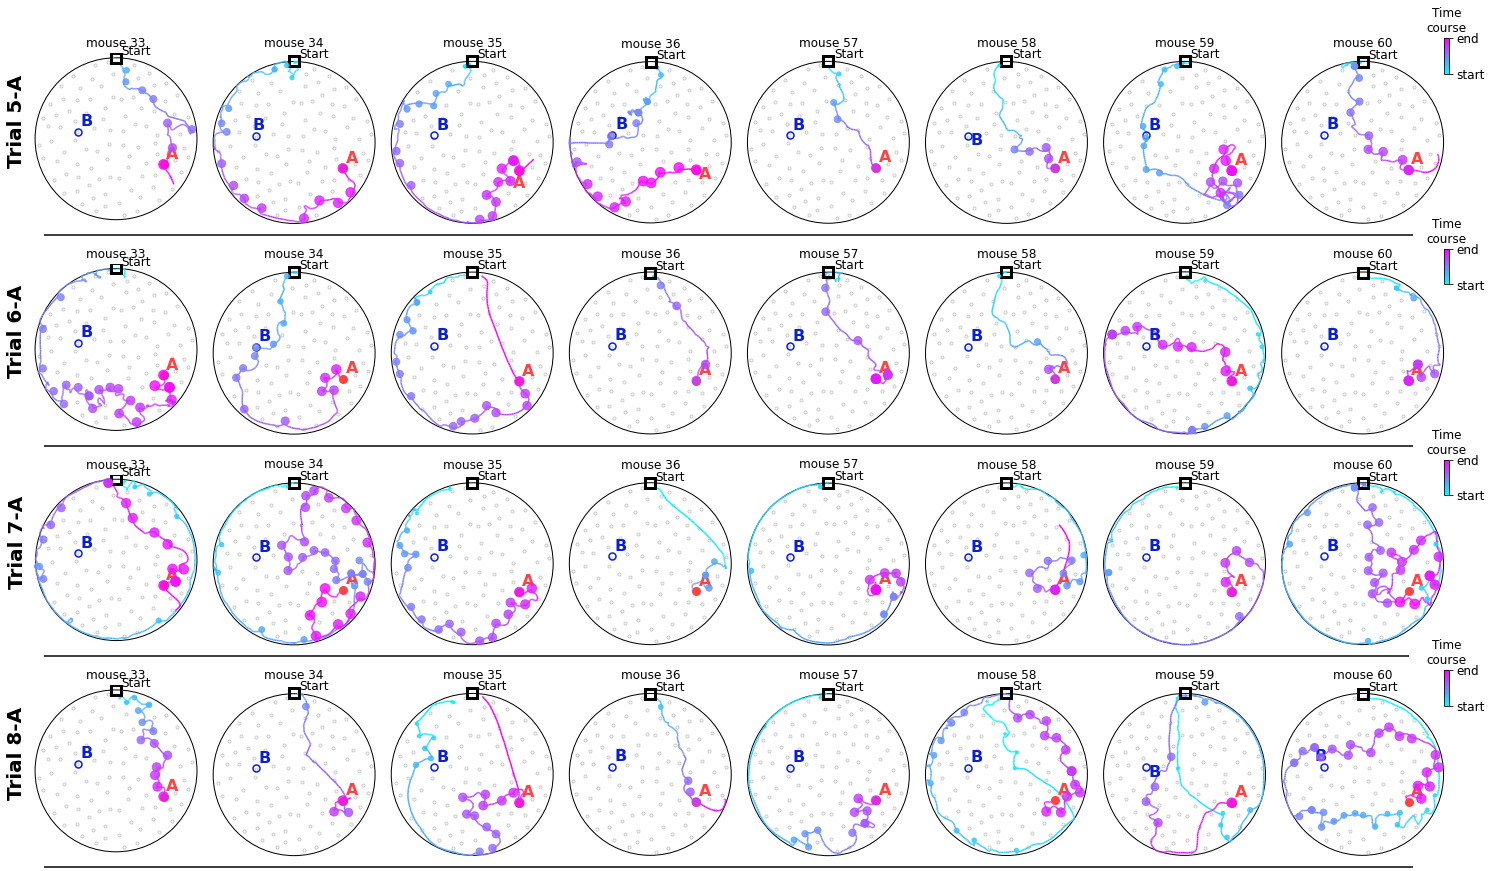

In [36]:
#import sys
#if 'modules.traj_analysis' in sys.modules.keys():
#    del sys.modules['modules.traj_analysis']
#if tran:
#    del tran
#import modules.traj_analysis as tran

import sys
if 'modules.plot_func' in sys.modules.keys():
    del sys.modules['modules.plot_func']
if pltt:
    del pltt
import modules.plot_func as pltt

trim_trajectories  = True
traj_alpha         = 0.5

hole_horizon          = 10.0 # cm
time_delay_after_food = 1.0 # sec
start_vec_align       = (0,1)

ignore_entrance_positions   = False
normalize_by                = 'max'
hole_horizon_hole_check     = 3.0 #cm
threshold_method            = 'ampv'
velocity_amplitude_fraction = 0.2
use_velocity_minima         = True
velocity_min_prominence     = 5.0 # cm/s

#if trim_trajectories:
#    tracks_to_plot = []
#    for tr,tr_trim in zip(all_trials_p2_complete,all_trials_p2):
#        t0 = 0.0 # seconds
#        if (int(tr.mouse_number) == 35):
#            t0 = 35.0 # the mouse doesn't move in the first 35 seconds
#        if (int(tr.mouse_number) == 34):
#            t0 = 20.0 # the mouse doesn't move in the first 35 seconds
#        tr_new = tran.slice_track_by_time(tr,t0=t0,t1=tr_trim.time[-1]+1,copy_track=True)
#        tr_new.time -= tr_new.time[0]
#        tracks_to_plot.append(tr_new)
#else:
#    tracks_to_plot = copy.deepcopy(all_trials_p2_complete)

first_trial       = 5
last_trial        = 8
tracks_to_plot    = list(misc.flatten_list(copy.deepcopy(all_trials_l1_rot[(first_trial-1):last_trial]),only_lists=True))
nrows_ncols_tuple = ((last_trial-first_trial+1),8)



all_trials = plib.rotate_trial_file(tracks_to_plot,start_vec_align,True)
k_slow,t_slow,r_slow,v_th = misc.unpack_list_of_tuples([ tran.find_slowing_down_close_to_hole(tr,hole_horizon_hole_check,threshold_method=threshold_method,gamma=velocity_amplitude_fraction,
                                                                                                 return_pos_from='hole',ignore_entrance_positions=ignore_entrance_positions,
                                                                                                 use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for tr in all_trials ])


color_red    = numpy.array((255, 66, 66,255))/255
color_blue   = numpy.array(( 10, 30,211,255))/255
color_orange = pltt.get_gradient(10,'orange')[0]
ax,lines,panel_ind=pltt.plot_all_tracks_2targets(all_trials,hole_horizon,time_delay_after_food,
                                       traj1Args=dict(color                  = plt.get_cmap('cool'),
                                                      line_gradient_variable = 'time',
                                                      alpha                  = traj_alpha,
                                                      show_colorbar=False,
                                                      startArgs     = dict(marker='s',markeredgewidth=3  ,markersize=10,color='k'       ,fillstyle='none',label='Start',labelArgs=dict(fontsize=12,va='bottom',ha='left',color='k',pad=(4,0)  ) ),
                                                      targetArgs    = dict(marker='o',markeredgewidth=3  ,markersize= 6,color=color_red ,fillstyle='full',label='A'    ,labelArgs=dict(fontsize=16,va='bottom',ha='left', fontweight='bold',color=color_red ,pad=(2,2))),
                                                      targetAltArgs = dict(marker='o',markeredgewidth=1.5,markersize= 7,color=color_blue,fillstyle='none',label='B'    ,labelArgs=dict(fontsize=16,va='bottom',ha='left', fontweight='bold',color=color_blue,pad=(2,2)))),
                                       traj2Args=dict(color=(0,0,0),alpha=traj_alpha),start_align_vector=start_vec_align,
                                       trim_trajectories=False,return_panel_ind=True,show_arena_holes=True,
                                       probe_title='',fig_size=(30,22),nrows_ncols_tuple=nrows_ncols_tuple,show_probetitle=False,fix_mouse_order_in_probe=False)
text_h = [tt for tt in misc.flatten_list(lines) if (('text' in str(type(tt))) and (tt.get_text() != 'Start'))]
text_h[11].set(va='top')   # A,i=0,j=3
text_h[3].set(ha='center') # A,i=1,j=1
text_h[-3].set(va='top')   # A,i=1,j=2
text_h[-1].set(ha='right') # A,i=1,j=3
text_h[6].set(va='top')    # B,i=0,j=1
text_h[4].set(va='top',ha='center',position=numpy.array(text_h[4].get_position())-numpy.array((2,6)))    # B,i=0,j=0


ax = pltt.tight_arena_panels(ax,adjust_title_position=False,dy_amid_panels=0.02)

cax = []
for k,(ind,r,tr) in enumerate(zip(k_slow,r_slow,tracks_to_plot)):
    t_seq = tr.time[ind]/tr.time[-1]
    i,j = numpy.unravel_index(k,nrows_ncols_tuple)
    pltt.plot_trajectory_points(r,ax=ax[i,j],use_scatter=True,s=1e2*t_seq,marker='o',c=plt.get_cmap('cool')(t_seq),zorder=10000,alpha=0.8)
    if j == 0:
        ax[i,j].text(-75,-20,'Trial %d-A'%plib.trial_to_number(tr.trial),rotation=90,va='bottom',ha='center',fontsize=20,fontweight='bold')
        x_lim = ax[i,j].get_xlim()
        y_lim = ax[i,j].get_xlim()
        lh = pltt.plot_horizontal_lines(-70,ax[i,j],xMin=-55,xMax=120*8,color='k',linewidth=1.5,linestyle='-')
        lh.set_clip_on(False)
        ax[i,j].set_xlim(x_lim)
        ax[i,j].set_ylim(y_lim)
    if j == (nrows_ncols_tuple[1]-1):
        cax.append(pltt._add_colorbar(ax[i,j],'cool',w_fraction_of_ax=0.03,h_fraction_of_ax=0.2,p0=(1.01,1.1),minmax_tick_labels=('start','end'),title='Time\ncourse',titleArgs=dict(color='k',fontsize=12),ticklabelsArgs=dict(color='k')))


if save_output_figures:
    detection_label = 'vmin' if use_velocity_minima else 'slowdown'
    plt.savefig(  f'{output_dir}/twotargets_trajectories_ALL_TRIALS_LEARNING_A_{first_trial}-{last_trial}_{detection_label}.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')



plt.show()

Learning A -- all trials: 9 to 12

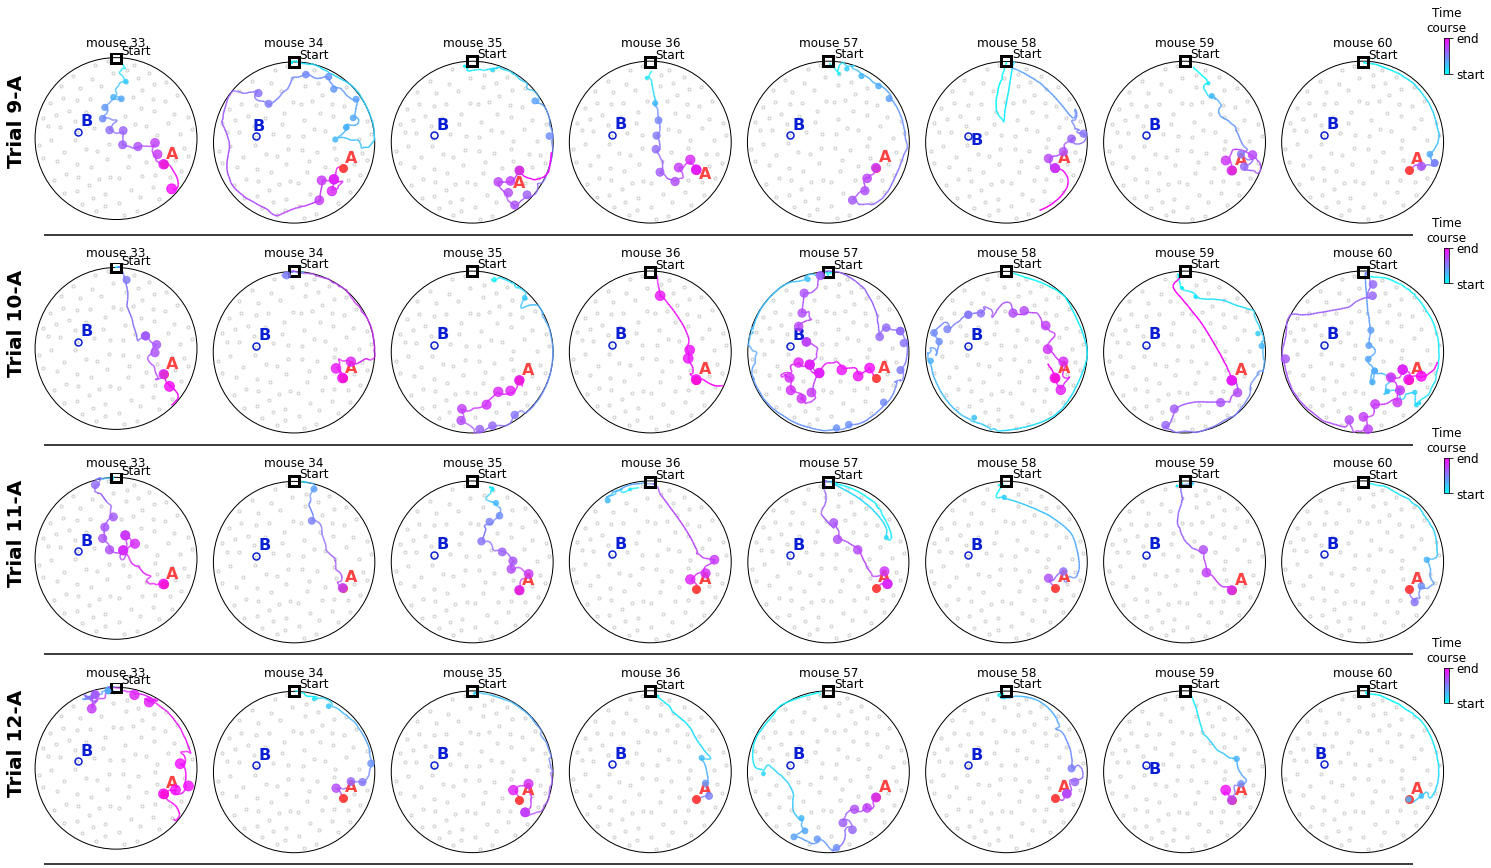

In [35]:
#import sys
#if 'modules.traj_analysis' in sys.modules.keys():
#    del sys.modules['modules.traj_analysis']
#if tran:
#    del tran
#import modules.traj_analysis as tran

import sys
if 'modules.plot_func' in sys.modules.keys():
    del sys.modules['modules.plot_func']
if pltt:
    del pltt
import modules.plot_func as pltt

trim_trajectories  = True
traj_alpha         = 0.5

hole_horizon          = 10.0 # cm
time_delay_after_food = 1.0 # sec
start_vec_align       = (0,1)

ignore_entrance_positions   = False
normalize_by                = 'max'
hole_horizon_hole_check     = 3.0 #cm
threshold_method            = 'ampv'
velocity_amplitude_fraction = 0.2
use_velocity_minima         = True
velocity_min_prominence     = 5.0 # cm/s

#if trim_trajectories:
#    tracks_to_plot = []
#    for tr,tr_trim in zip(all_trials_p2_complete,all_trials_p2):
#        t0 = 0.0 # seconds
#        if (int(tr.mouse_number) == 35):
#            t0 = 35.0 # the mouse doesn't move in the first 35 seconds
#        if (int(tr.mouse_number) == 34):
#            t0 = 20.0 # the mouse doesn't move in the first 35 seconds
#        tr_new = tran.slice_track_by_time(tr,t0=t0,t1=tr_trim.time[-1]+1,copy_track=True)
#        tr_new.time -= tr_new.time[0]
#        tracks_to_plot.append(tr_new)
#else:
#    tracks_to_plot = copy.deepcopy(all_trials_p2_complete)

first_trial       = 9
last_trial        = 12
tracks_to_plot    = list(misc.flatten_list(copy.deepcopy(all_trials_l1_rot[(first_trial-1):last_trial]),only_lists=True))
nrows_ncols_tuple = ((last_trial-first_trial+1),8)



all_trials = plib.rotate_trial_file(tracks_to_plot,start_vec_align,True)
k_slow,t_slow,r_slow,v_th = misc.unpack_list_of_tuples([ tran.find_slowing_down_close_to_hole(tr,hole_horizon_hole_check,threshold_method=threshold_method,gamma=velocity_amplitude_fraction,
                                                                                                 return_pos_from='hole',ignore_entrance_positions=ignore_entrance_positions,
                                                                                                 use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for tr in all_trials ])


color_red    = numpy.array((255, 66, 66,255))/255
color_blue   = numpy.array(( 10, 30,211,255))/255
color_orange = pltt.get_gradient(10,'orange')[0]
ax,lines,panel_ind=pltt.plot_all_tracks_2targets(all_trials,hole_horizon,time_delay_after_food,
                                       traj1Args=dict(color                  = plt.get_cmap('cool'),
                                                      line_gradient_variable = 'time',
                                                      alpha                  = traj_alpha,
                                                      show_colorbar=False,
                                                      startArgs     = dict(marker='s',markeredgewidth=3  ,markersize=10,color='k'       ,fillstyle='none',label='Start',labelArgs=dict(fontsize=12,va='bottom',ha='left',color='k',pad=(4,0)  ) ),
                                                      targetArgs    = dict(marker='o',markeredgewidth=3  ,markersize= 6,color=color_red ,fillstyle='full',label='A'    ,labelArgs=dict(fontsize=16,va='bottom',ha='left', fontweight='bold',color=color_red ,pad=(2,2))),
                                                      targetAltArgs = dict(marker='o',markeredgewidth=1.5,markersize= 7,color=color_blue,fillstyle='none',label='B'    ,labelArgs=dict(fontsize=16,va='bottom',ha='left', fontweight='bold',color=color_blue,pad=(2,2)))),
                                       traj2Args=dict(color=(0,0,0),alpha=traj_alpha),start_align_vector=start_vec_align,
                                       trim_trajectories=False,return_panel_ind=True,show_arena_holes=True,
                                       probe_title='',fig_size=(30,22),nrows_ncols_tuple=nrows_ncols_tuple,show_probetitle=False,fix_mouse_order_in_probe=False)
text_h = [tt for tt in misc.flatten_list(lines) if (('text' in str(type(tt))) and (tt.get_text() != 'Start'))]
text_h[11].set(va='top')   # A,i=0,j=3
text_h[3].set(ha='center') # A,i=1,j=1
text_h[-3].set(va='top')   # A,i=1,j=2
text_h[-1].set(ha='right') # A,i=1,j=3
text_h[6].set(va='top')    # B,i=0,j=1
text_h[4].set(va='top',ha='center',position=numpy.array(text_h[4].get_position())-numpy.array((2,6)))    # B,i=0,j=0


ax = pltt.tight_arena_panels(ax,adjust_title_position=False,dy_amid_panels=0.02)

cax = []
for k,(ind,r,tr) in enumerate(zip(k_slow,r_slow,tracks_to_plot)):
    t_seq = tr.time[ind]/tr.time[-1]
    i,j = numpy.unravel_index(k,nrows_ncols_tuple)
    pltt.plot_trajectory_points(r,ax=ax[i,j],use_scatter=True,s=1e2*t_seq,marker='o',c=plt.get_cmap('cool')(t_seq),zorder=10000,alpha=0.8)
    if j == 0:
        ax[i,j].text(-75,-20,'Trial %d-A'%plib.trial_to_number(tr.trial),rotation=90,va='bottom',ha='center',fontsize=20,fontweight='bold')
        x_lim = ax[i,j].get_xlim()
        y_lim = ax[i,j].get_xlim()
        lh = pltt.plot_horizontal_lines(-70,ax[i,j],xMin=-55,xMax=120*8,color='k',linewidth=1.5,linestyle='-')
        lh.set_clip_on(False)
        ax[i,j].set_xlim(x_lim)
        ax[i,j].set_ylim(y_lim)
    if j == (nrows_ncols_tuple[1]-1):
        cax.append(pltt._add_colorbar(ax[i,j],'cool',w_fraction_of_ax=0.03,h_fraction_of_ax=0.2,p0=(1.01,1.1),minmax_tick_labels=('start','end'),title='Time\ncourse',titleArgs=dict(color='k',fontsize=12),ticklabelsArgs=dict(color='k')))


if save_output_figures:
    detection_label = 'vmin' if use_velocity_minima else 'slowdown'
    plt.savefig(  f'{output_dir}/twotargets_trajectories_ALL_TRIALS_LEARNING_A_{first_trial}-{last_trial}_{detection_label}.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')



plt.show()

Learning A -- all trials: 13 to 16

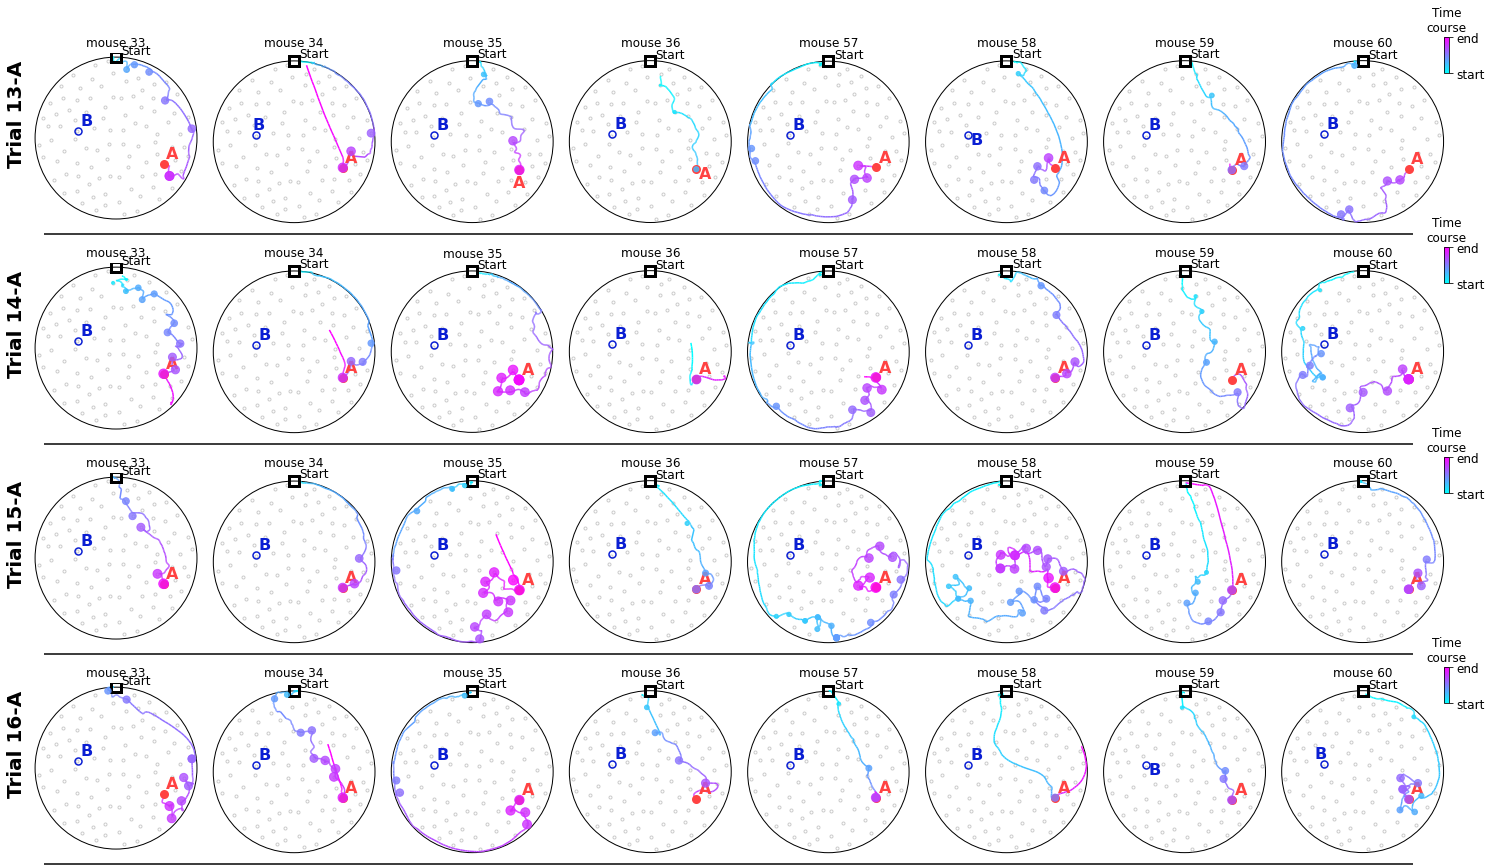

In [33]:
#import sys
#if 'modules.traj_analysis' in sys.modules.keys():
#    del sys.modules['modules.traj_analysis']
#if tran:
#    del tran
#import modules.traj_analysis as tran

import sys
if 'modules.plot_func' in sys.modules.keys():
    del sys.modules['modules.plot_func']
if pltt:
    del pltt
import modules.plot_func as pltt

trim_trajectories  = True
traj_alpha         = 0.5

hole_horizon          = 10.0 # cm
time_delay_after_food = 1.0 # sec
start_vec_align       = (0,1)

ignore_entrance_positions   = False
normalize_by                = 'max'
hole_horizon_hole_check     = 3.0 #cm
threshold_method            = 'ampv'
velocity_amplitude_fraction = 0.2
use_velocity_minima         = True
velocity_min_prominence     = 5.0 # cm/s

#if trim_trajectories:
#    tracks_to_plot = []
#    for tr,tr_trim in zip(all_trials_p2_complete,all_trials_p2):
#        t0 = 0.0 # seconds
#        if (int(tr.mouse_number) == 35):
#            t0 = 35.0 # the mouse doesn't move in the first 35 seconds
#        if (int(tr.mouse_number) == 34):
#            t0 = 20.0 # the mouse doesn't move in the first 35 seconds
#        tr_new = tran.slice_track_by_time(tr,t0=t0,t1=tr_trim.time[-1]+1,copy_track=True)
#        tr_new.time -= tr_new.time[0]
#        tracks_to_plot.append(tr_new)
#else:
#    tracks_to_plot = copy.deepcopy(all_trials_p2_complete)

first_trial       = 13
last_trial        = 16
tracks_to_plot    = list(misc.flatten_list(copy.deepcopy(all_trials_l1_rot[(first_trial-1):last_trial]),only_lists=True))
nrows_ncols_tuple = ((last_trial-first_trial+1),8)



all_trials = plib.rotate_trial_file(tracks_to_plot,start_vec_align,True)
k_slow,t_slow,r_slow,v_th = misc.unpack_list_of_tuples([ tran.find_slowing_down_close_to_hole(tr,hole_horizon_hole_check,threshold_method=threshold_method,gamma=velocity_amplitude_fraction,
                                                                                                 return_pos_from='hole',ignore_entrance_positions=ignore_entrance_positions,
                                                                                                 use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for tr in all_trials ])


color_red    = numpy.array((255, 66, 66,255))/255
color_blue   = numpy.array(( 10, 30,211,255))/255
color_orange = pltt.get_gradient(10,'orange')[0]
ax,lines,panel_ind=pltt.plot_all_tracks_2targets(all_trials,hole_horizon,time_delay_after_food,
                                       traj1Args=dict(color                  = plt.get_cmap('cool'),
                                                      line_gradient_variable = 'time',
                                                      alpha                  = traj_alpha,
                                                      show_colorbar=False,
                                                      startArgs     = dict(marker='s',markeredgewidth=3  ,markersize=10,color='k'       ,fillstyle='none',label='Start',labelArgs=dict(fontsize=12,va='bottom',ha='left',color='k',pad=(4,0)  ) ),
                                                      targetArgs    = dict(marker='o',markeredgewidth=3  ,markersize= 6,color=color_red ,fillstyle='full',label='A'    ,labelArgs=dict(fontsize=16,va='bottom',ha='left', fontweight='bold',color=color_red ,pad=(2,2))),
                                                      targetAltArgs = dict(marker='o',markeredgewidth=1.5,markersize= 7,color=color_blue,fillstyle='none',label='B'    ,labelArgs=dict(fontsize=16,va='bottom',ha='left', fontweight='bold',color=color_blue,pad=(2,2)))),
                                       traj2Args=dict(color=(0,0,0),alpha=traj_alpha),start_align_vector=start_vec_align,
                                       trim_trajectories=False,return_panel_ind=True,show_arena_holes=True,
                                       probe_title='',fig_size=(30,22),nrows_ncols_tuple=nrows_ncols_tuple,show_probetitle=False,fix_mouse_order_in_probe=False)
text_h = [tt for tt in misc.flatten_list(lines) if (('text' in str(type(tt))) and (tt.get_text() != 'Start'))]
text_h[11].set(va='top')   # A,i=0,j=3
text_h[3].set(ha='center') # A,i=1,j=1
text_h[-3].set(va='top')   # A,i=1,j=2
text_h[-1].set(ha='right') # A,i=1,j=3
text_h[6].set(va='top')    # B,i=0,j=1
text_h[4].set(va='top',ha='center',position=numpy.array(text_h[4].get_position())-numpy.array((2,6)))    # B,i=0,j=0


ax = pltt.tight_arena_panels(ax,adjust_title_position=False,dy_amid_panels=0.02)

cax = []
for k,(ind,r,tr) in enumerate(zip(k_slow,r_slow,tracks_to_plot)):
    t_seq = tr.time[ind]/tr.time[-1]
    i,j = numpy.unravel_index(k,nrows_ncols_tuple)
    pltt.plot_trajectory_points(r,ax=ax[i,j],use_scatter=True,s=1e2*t_seq,marker='o',c=plt.get_cmap('cool')(t_seq),zorder=10000,alpha=0.8)
    if j == 0:
        ax[i,j].text(-75,-20,'Trial %d-A'%plib.trial_to_number(tr.trial),rotation=90,va='bottom',ha='center',fontsize=20,fontweight='bold')
        x_lim = ax[i,j].get_xlim()
        y_lim = ax[i,j].get_xlim()
        lh = pltt.plot_horizontal_lines(-70,ax[i,j],xMin=-55,xMax=120*8,color='k',linewidth=1.5,linestyle='-')
        lh.set_clip_on(False)
        ax[i,j].set_xlim(x_lim)
        ax[i,j].set_ylim(y_lim)
    if j == (nrows_ncols_tuple[1]-1):
        cax.append(pltt._add_colorbar(ax[i,j],'cool',w_fraction_of_ax=0.03,h_fraction_of_ax=0.2,p0=(1.01,1.1),minmax_tick_labels=('start','end'),title='Time\ncourse',titleArgs=dict(color='k',fontsize=12),ticklabelsArgs=dict(color='k')))


if save_output_figures:
    detection_label = 'vmin' if use_velocity_minima else 'slowdown'
    plt.savefig(  f'{output_dir}/twotargets_trajectories_ALL_TRIALS_LEARNING_A_{first_trial}-{last_trial}_{detection_label}.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')



plt.show()

Learning A -- all trials: 17 to 18

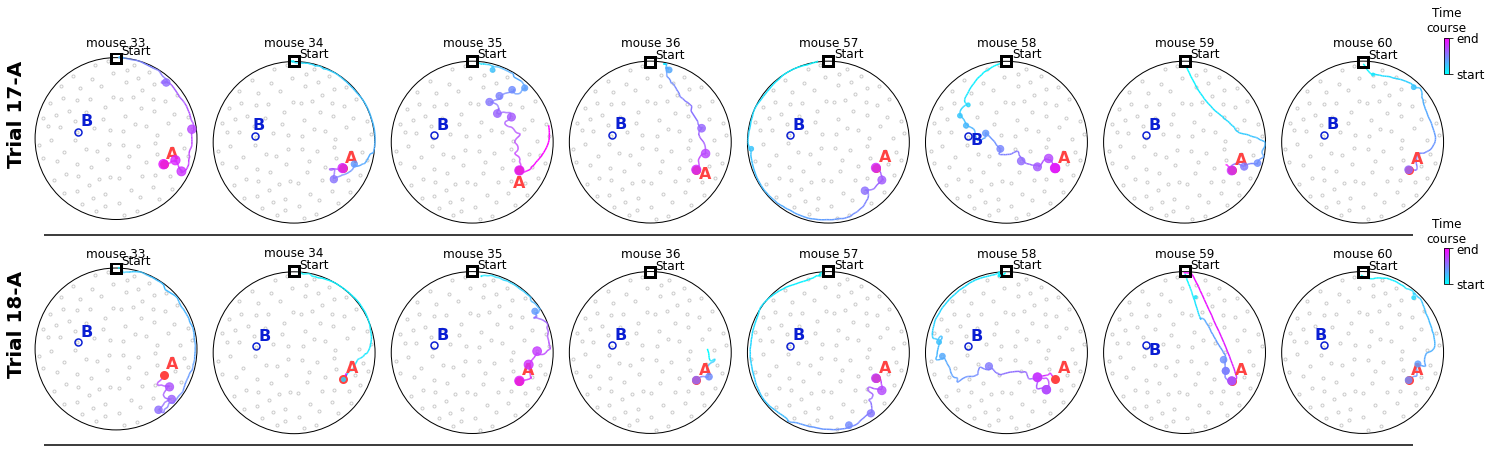

In [34]:
#import sys
#if 'modules.traj_analysis' in sys.modules.keys():
#    del sys.modules['modules.traj_analysis']
#if tran:
#    del tran
#import modules.traj_analysis as tran

import sys
if 'modules.plot_func' in sys.modules.keys():
    del sys.modules['modules.plot_func']
if pltt:
    del pltt
import modules.plot_func as pltt

trim_trajectories  = True
traj_alpha         = 0.5

hole_horizon          = 10.0 # cm
time_delay_after_food = 1.0 # sec
start_vec_align       = (0,1)

ignore_entrance_positions   = False
normalize_by                = 'max'
hole_horizon_hole_check     = 3.0 #cm
threshold_method            = 'ampv'
velocity_amplitude_fraction = 0.2
use_velocity_minima         = True
velocity_min_prominence     = 5.0 # cm/s

#if trim_trajectories:
#    tracks_to_plot = []
#    for tr,tr_trim in zip(all_trials_p2_complete,all_trials_p2):
#        t0 = 0.0 # seconds
#        if (int(tr.mouse_number) == 35):
#            t0 = 35.0 # the mouse doesn't move in the first 35 seconds
#        if (int(tr.mouse_number) == 34):
#            t0 = 20.0 # the mouse doesn't move in the first 35 seconds
#        tr_new = tran.slice_track_by_time(tr,t0=t0,t1=tr_trim.time[-1]+1,copy_track=True)
#        tr_new.time -= tr_new.time[0]
#        tracks_to_plot.append(tr_new)
#else:
#    tracks_to_plot = copy.deepcopy(all_trials_p2_complete)

first_trial       = 17
last_trial        = 18
tracks_to_plot    = list(misc.flatten_list(copy.deepcopy(all_trials_l1_rot[(first_trial-1):last_trial]),only_lists=True))
nrows_ncols_tuple = ((last_trial-first_trial+1),8)



all_trials = plib.rotate_trial_file(tracks_to_plot,start_vec_align,True)
k_slow,t_slow,r_slow,v_th = misc.unpack_list_of_tuples([ tran.find_slowing_down_close_to_hole(tr,hole_horizon_hole_check,threshold_method=threshold_method,gamma=velocity_amplitude_fraction,
                                                                                                 return_pos_from='hole',ignore_entrance_positions=ignore_entrance_positions,
                                                                                                 use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for tr in all_trials ])


color_red    = numpy.array((255, 66, 66,255))/255
color_blue   = numpy.array(( 10, 30,211,255))/255
color_orange = pltt.get_gradient(10,'orange')[0]
ax,lines,panel_ind=pltt.plot_all_tracks_2targets(all_trials,hole_horizon,time_delay_after_food,
                                       traj1Args=dict(color                  = plt.get_cmap('cool'),
                                                      line_gradient_variable = 'time',
                                                      alpha                  = traj_alpha,
                                                      show_colorbar=False,
                                                      startArgs     = dict(marker='s',markeredgewidth=3  ,markersize=10,color='k'       ,fillstyle='none',label='Start',labelArgs=dict(fontsize=12,va='bottom',ha='left',color='k',pad=(4,0)  ) ),
                                                      targetArgs    = dict(marker='o',markeredgewidth=3  ,markersize= 6,color=color_red ,fillstyle='full',label='A'    ,labelArgs=dict(fontsize=16,va='bottom',ha='left', fontweight='bold',color=color_red ,pad=(2,2))),
                                                      targetAltArgs = dict(marker='o',markeredgewidth=1.5,markersize= 7,color=color_blue,fillstyle='none',label='B'    ,labelArgs=dict(fontsize=16,va='bottom',ha='left', fontweight='bold',color=color_blue,pad=(2,2)))),
                                       traj2Args=dict(color=(0,0,0),alpha=traj_alpha),start_align_vector=start_vec_align,
                                       trim_trajectories=False,return_panel_ind=True,show_arena_holes=True,
                                       probe_title='',fig_size=(30,22),nrows_ncols_tuple=nrows_ncols_tuple,show_probetitle=False,fix_mouse_order_in_probe=False)
text_h = [tt for tt in misc.flatten_list(lines) if (('text' in str(type(tt))) and (tt.get_text() != 'Start'))]
text_h[11].set(va='top')   # A,i=0,j=3
text_h[3].set(ha='center') # A,i=1,j=1
text_h[-3].set(va='top')   # A,i=1,j=2
text_h[-1].set(ha='right') # A,i=1,j=3
text_h[6].set(va='top')    # B,i=0,j=1
text_h[4].set(va='top',ha='center',position=numpy.array(text_h[4].get_position())-numpy.array((2,6)))    # B,i=0,j=0


ax = pltt.tight_arena_panels(ax,adjust_title_position=False,dy_amid_panels=0.02)

cax = []
for k,(ind,r,tr) in enumerate(zip(k_slow,r_slow,tracks_to_plot)):
    t_seq = tr.time[ind]/tr.time[-1]
    i,j = numpy.unravel_index(k,nrows_ncols_tuple)
    pltt.plot_trajectory_points(r,ax=ax[i,j],use_scatter=True,s=1e2*t_seq,marker='o',c=plt.get_cmap('cool')(t_seq),zorder=10000,alpha=0.8)
    if j == 0:
        ax[i,j].text(-75,-20,'Trial %d-A'%plib.trial_to_number(tr.trial),rotation=90,va='bottom',ha='center',fontsize=20,fontweight='bold')
        x_lim = ax[i,j].get_xlim()
        y_lim = ax[i,j].get_xlim()
        lh = pltt.plot_horizontal_lines(-70,ax[i,j],xMin=-55,xMax=120*8,color='k',linewidth=1.5,linestyle='-')
        lh.set_clip_on(False)
        ax[i,j].set_xlim(x_lim)
        ax[i,j].set_ylim(y_lim)
    if j == (nrows_ncols_tuple[1]-1):
        cax.append(pltt._add_colorbar(ax[i,j],'cool',w_fraction_of_ax=0.03,h_fraction_of_ax=0.2,p0=(1.01,1.1),minmax_tick_labels=('start','end'),title='Time\ncourse',titleArgs=dict(color='k',fontsize=12),ticklabelsArgs=dict(color='k')))


if save_output_figures:
    detection_label = 'vmin' if use_velocity_minima else 'slowdown'
    plt.savefig(  f'{output_dir}/twotargets_trajectories_ALL_TRIALS_LEARNING_A_{first_trial}-{last_trial}_{detection_label}.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')



plt.show()

Learning B -- all trials: 1 to 4

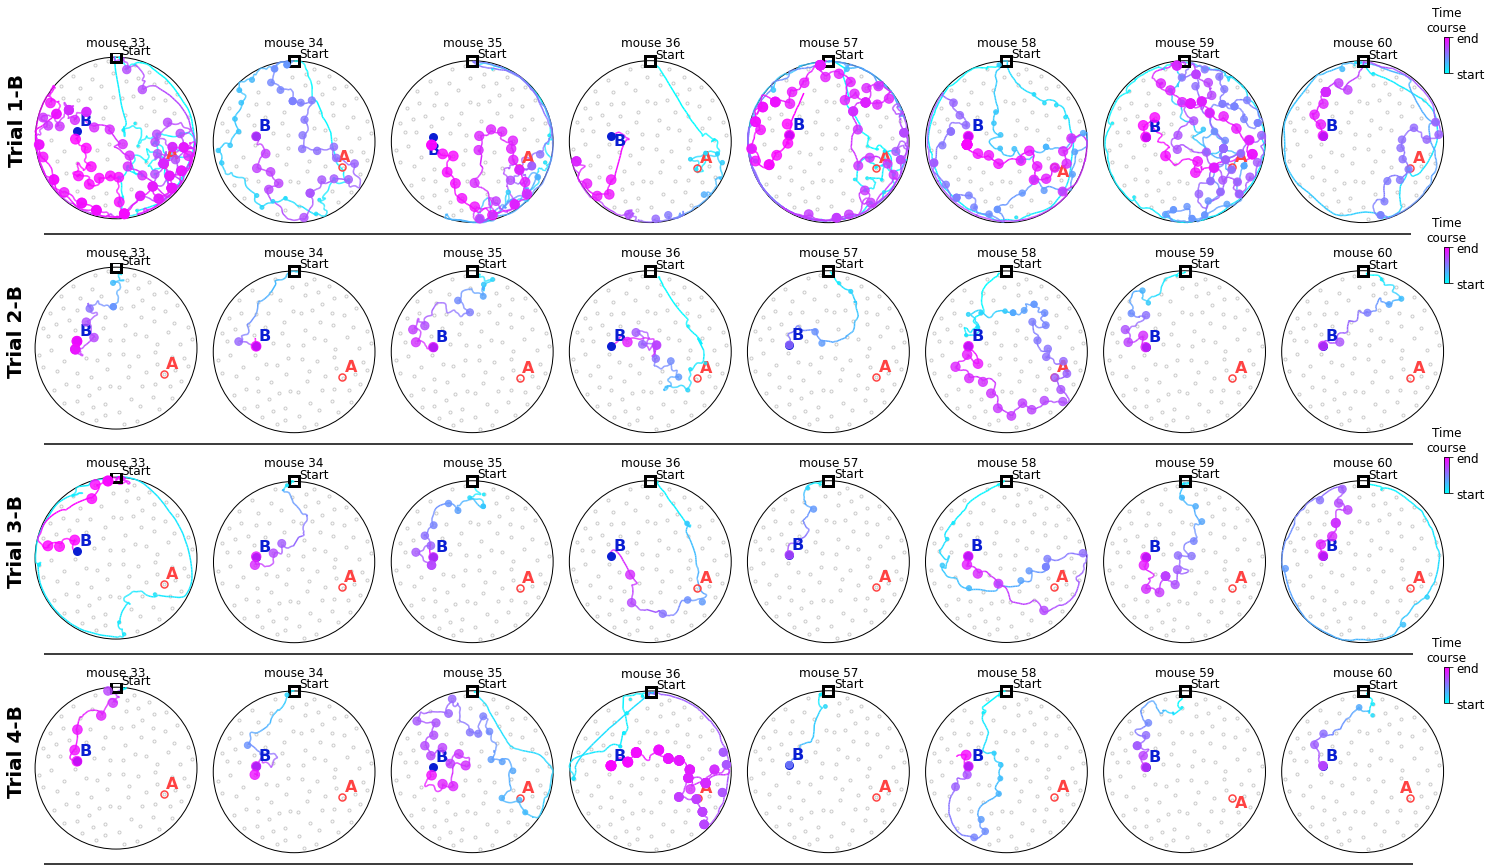

In [32]:
#import sys
#if 'modules.traj_analysis' in sys.modules.keys():
#    del sys.modules['modules.traj_analysis']
#if tran:
#    del tran
#import modules.traj_analysis as tran

import sys
if 'modules.plot_func' in sys.modules.keys():
    del sys.modules['modules.plot_func']
if pltt:
    del pltt
import modules.plot_func as pltt

trim_trajectories  = True
traj_alpha         = 0.5

hole_horizon          = 10.0 # cm
time_delay_after_food = 1.0 # sec
start_vec_align       = (0,1)

ignore_entrance_positions   = False
normalize_by                = 'max'
hole_horizon_hole_check     = 3.0 #cm
threshold_method            = 'ampv'
velocity_amplitude_fraction = 0.2
use_velocity_minima         = True
velocity_min_prominence     = 5.0 # cm/s

#if trim_trajectories:
#    tracks_to_plot = []
#    for tr,tr_trim in zip(all_trials_p2_complete,all_trials_p2):
#        t0 = 0.0 # seconds
#        if (int(tr.mouse_number) == 35):
#            t0 = 35.0 # the mouse doesn't move in the first 35 seconds
#        if (int(tr.mouse_number) == 34):
#            t0 = 20.0 # the mouse doesn't move in the first 35 seconds
#        tr_new = tran.slice_track_by_time(tr,t0=t0,t1=tr_trim.time[-1]+1,copy_track=True)
#        tr_new.time -= tr_new.time[0]
#        tracks_to_plot.append(tr_new)
#else:
#    tracks_to_plot = copy.deepcopy(all_trials_p2_complete)

first_trial       = 1
last_trial        = 4
tracks_to_plot    = list(misc.flatten_list(copy.deepcopy(all_trials_l2_rot[(first_trial-1):last_trial]),only_lists=True))
nrows_ncols_tuple = ((last_trial-first_trial+1),8)



all_trials = plib.rotate_trial_file(tracks_to_plot,start_vec_align,True)
k_slow,t_slow,r_slow,v_th = misc.unpack_list_of_tuples([ tran.find_slowing_down_close_to_hole(tr,hole_horizon_hole_check,threshold_method=threshold_method,gamma=velocity_amplitude_fraction,
                                                                                                 return_pos_from='hole',ignore_entrance_positions=ignore_entrance_positions,
                                                                                                 use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for tr in all_trials ])


color_red    = numpy.array((255, 66, 66,255))/255
color_blue   = numpy.array(( 10, 30,211,255))/255
color_orange = pltt.get_gradient(10,'orange')[0]
ax,lines,panel_ind=pltt.plot_all_tracks_2targets(all_trials,hole_horizon,time_delay_after_food,
                                       traj1Args=dict(color                  = plt.get_cmap('cool'),
                                                      line_gradient_variable = 'time',
                                                      alpha                  = traj_alpha,
                                                      show_colorbar=False,
                                                      startArgs     = dict(marker='s',markeredgewidth=3  ,markersize=10,color='k'       ,fillstyle='none',label='Start',labelArgs=dict(fontsize=12,va='bottom',ha='left',color='k',pad=(4,0)  ) ),
                                                      targetArgs    = dict(marker='o',markeredgewidth=3  ,markersize= 6,color=color_blue,fillstyle='full',label='B'    ,labelArgs=dict(fontsize=16,va='bottom',ha='left', fontweight='bold',color=color_blue,pad=(2,2))),
                                                      targetAltArgs = dict(marker='o',markeredgewidth=1.5,markersize= 7,color=color_red ,fillstyle='none',label='A'    ,labelArgs=dict(fontsize=16,va='bottom',ha='left', fontweight='bold',color=color_red ,pad=(2,2)))),
                                       traj2Args=dict(color=(0,0,0),alpha=traj_alpha),start_align_vector=start_vec_align,
                                       trim_trajectories=False,return_panel_ind=True,show_arena_holes=True,
                                       probe_title='',fig_size=(30,22),nrows_ncols_tuple=nrows_ncols_tuple,show_probetitle=False,fix_mouse_order_in_probe=False)
text_h = [tt for tt in misc.flatten_list(lines) if (('text' in str(type(tt))) and (tt.get_text() != 'Start'))]
text_h[11].set(va='top')   # A,i=0,j=3
text_h[3].set(ha='center') # A,i=1,j=1
text_h[-3].set(va='top')   # A,i=1,j=2
text_h[-1].set(ha='right') # A,i=1,j=3
text_h[6].set(va='top')    # B,i=0,j=1
text_h[4].set(va='top',ha='center',position=numpy.array(text_h[4].get_position())-numpy.array((2,6)))    # B,i=0,j=0


ax = pltt.tight_arena_panels(ax,adjust_title_position=False,dy_amid_panels=0.02)

trial_number = first_trial - 1
cax = []
for k,(ind,r,tr) in enumerate(zip(k_slow,r_slow,tracks_to_plot)):
    t_seq = tr.time[ind]/tr.time[-1]
    i,j = numpy.unravel_index(k,nrows_ncols_tuple)
    pltt.plot_trajectory_points(r,ax=ax[i,j],use_scatter=True,s=1e2*t_seq,marker='o',c=plt.get_cmap('cool')(t_seq),zorder=10000,alpha=0.8)
    if j == 0:
        trial_number += 1
        ax[i,j].text(-75,-20,'Trial %d-B'%trial_number,rotation=90,va='bottom',ha='center',fontsize=20,fontweight='bold')
        x_lim = ax[i,j].get_xlim()
        y_lim = ax[i,j].get_xlim()
        lh = pltt.plot_horizontal_lines(-70,ax[i,j],xMin=-55,xMax=120*8,color='k',linewidth=1.5,linestyle='-')
        lh.set_clip_on(False)
        ax[i,j].set_xlim(x_lim)
        ax[i,j].set_ylim(y_lim)
    if j == (nrows_ncols_tuple[1]-1):
        cax.append(pltt._add_colorbar(ax[i,j],'cool',w_fraction_of_ax=0.03,h_fraction_of_ax=0.2,p0=(1.01,1.1),minmax_tick_labels=('start','end'),title='Time\ncourse',titleArgs=dict(color='k',fontsize=12),ticklabelsArgs=dict(color='k')))


if save_output_figures:
    detection_label = 'vmin' if use_velocity_minima else 'slowdown'
    plt.savefig(  f'{output_dir}/twotargets_trajectories_ALL_TRIALS_LEARNING_B_{first_trial}-{last_trial}_{detection_label}.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')



plt.show()

Learning B -- all trials: 5 to 8

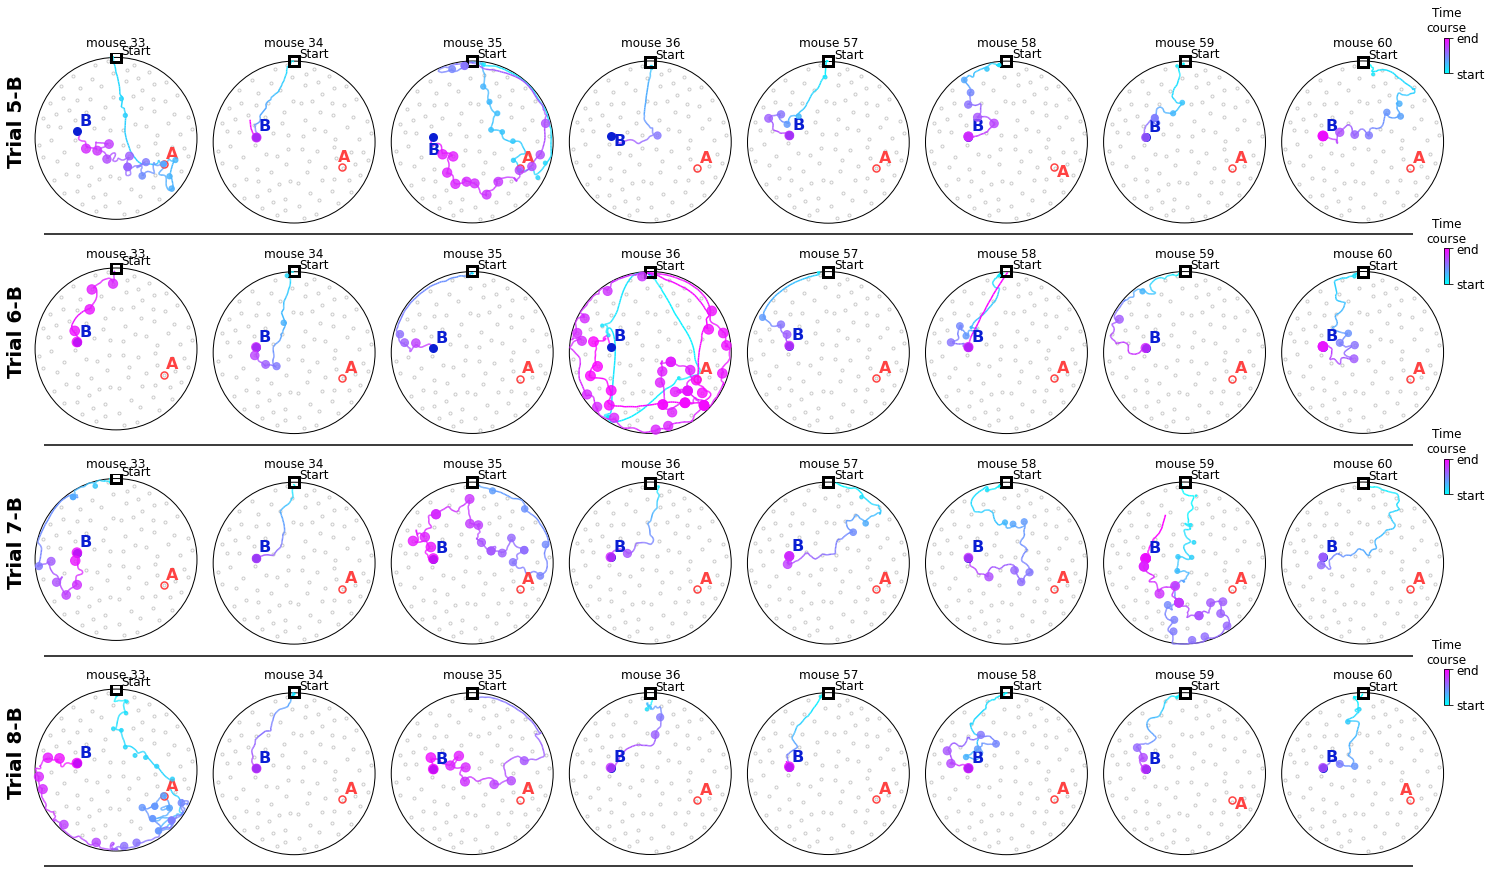

In [38]:
#import sys
#if 'modules.traj_analysis' in sys.modules.keys():
#    del sys.modules['modules.traj_analysis']
#if tran:
#    del tran
#import modules.traj_analysis as tran

import sys
if 'modules.plot_func' in sys.modules.keys():
    del sys.modules['modules.plot_func']
if pltt:
    del pltt
import modules.plot_func as pltt

trim_trajectories  = True
traj_alpha         = 0.5

hole_horizon          = 10.0 # cm
time_delay_after_food = 1.0 # sec
start_vec_align       = (0,1)

ignore_entrance_positions   = False
normalize_by                = 'max'
hole_horizon_hole_check     = 3.0 #cm
threshold_method            = 'ampv'
velocity_amplitude_fraction = 0.2
use_velocity_minima         = True
velocity_min_prominence     = 5.0 # cm/s

#if trim_trajectories:
#    tracks_to_plot = []
#    for tr,tr_trim in zip(all_trials_p2_complete,all_trials_p2):
#        t0 = 0.0 # seconds
#        if (int(tr.mouse_number) == 35):
#            t0 = 35.0 # the mouse doesn't move in the first 35 seconds
#        if (int(tr.mouse_number) == 34):
#            t0 = 20.0 # the mouse doesn't move in the first 35 seconds
#        tr_new = tran.slice_track_by_time(tr,t0=t0,t1=tr_trim.time[-1]+1,copy_track=True)
#        tr_new.time -= tr_new.time[0]
#        tracks_to_plot.append(tr_new)
#else:
#    tracks_to_plot = copy.deepcopy(all_trials_p2_complete)

first_trial       = 5
last_trial        = 8
tracks_to_plot    = list(misc.flatten_list(copy.deepcopy(all_trials_l2_rot[(first_trial-1):last_trial]),only_lists=True))
nrows_ncols_tuple = ((last_trial-first_trial+1),8)



all_trials = plib.rotate_trial_file(tracks_to_plot,start_vec_align,True)
k_slow,t_slow,r_slow,v_th = misc.unpack_list_of_tuples([ tran.find_slowing_down_close_to_hole(tr,hole_horizon_hole_check,threshold_method=threshold_method,gamma=velocity_amplitude_fraction,
                                                                                                 return_pos_from='hole',ignore_entrance_positions=ignore_entrance_positions,
                                                                                                 use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for tr in all_trials ])


color_red    = numpy.array((255, 66, 66,255))/255
color_blue   = numpy.array(( 10, 30,211,255))/255
color_orange = pltt.get_gradient(10,'orange')[0]
ax,lines,panel_ind=pltt.plot_all_tracks_2targets(all_trials,hole_horizon,time_delay_after_food,
                                       traj1Args=dict(color                  = plt.get_cmap('cool'),
                                                      line_gradient_variable = 'time',
                                                      alpha                  = traj_alpha,
                                                      show_colorbar=False,
                                                      startArgs     = dict(marker='s',markeredgewidth=3  ,markersize=10,color='k'       ,fillstyle='none',label='Start',labelArgs=dict(fontsize=12,va='bottom',ha='left',color='k',pad=(4,0)  ) ),
                                                      targetArgs    = dict(marker='o',markeredgewidth=3  ,markersize= 6,color=color_blue,fillstyle='full',label='B'    ,labelArgs=dict(fontsize=16,va='bottom',ha='left', fontweight='bold',color=color_blue,pad=(2,2))),
                                                      targetAltArgs = dict(marker='o',markeredgewidth=1.5,markersize= 7,color=color_red ,fillstyle='none',label='A'    ,labelArgs=dict(fontsize=16,va='bottom',ha='left', fontweight='bold',color=color_red ,pad=(2,2)))),
                                       traj2Args=dict(color=(0,0,0),alpha=traj_alpha),start_align_vector=start_vec_align,
                                       trim_trajectories=False,return_panel_ind=True,show_arena_holes=True,
                                       probe_title='',fig_size=(30,22),nrows_ncols_tuple=nrows_ncols_tuple,show_probetitle=False,fix_mouse_order_in_probe=False)
text_h = [tt for tt in misc.flatten_list(lines) if (('text' in str(type(tt))) and (tt.get_text() != 'Start'))]
text_h[11].set(va='top')   # A,i=0,j=3
text_h[3].set(ha='center') # A,i=1,j=1
text_h[-3].set(va='top')   # A,i=1,j=2
text_h[-1].set(ha='right') # A,i=1,j=3
text_h[6].set(va='top')    # B,i=0,j=1
text_h[4].set(va='top',ha='center',position=numpy.array(text_h[4].get_position())-numpy.array((2,6)))    # B,i=0,j=0


ax = pltt.tight_arena_panels(ax,adjust_title_position=False,dy_amid_panels=0.02)

trial_number = first_trial - 1
cax = []
for k,(ind,r,tr) in enumerate(zip(k_slow,r_slow,tracks_to_plot)):
    t_seq = tr.time[ind]/tr.time[-1]
    i,j = numpy.unravel_index(k,nrows_ncols_tuple)
    pltt.plot_trajectory_points(r,ax=ax[i,j],use_scatter=True,s=1e2*t_seq,marker='o',c=plt.get_cmap('cool')(t_seq),zorder=10000,alpha=0.8)
    if j == 0:
        trial_number += 1
        ax[i,j].text(-75,-20,'Trial %d-B'%trial_number,rotation=90,va='bottom',ha='center',fontsize=20,fontweight='bold')
        x_lim = ax[i,j].get_xlim()
        y_lim = ax[i,j].get_xlim()
        lh = pltt.plot_horizontal_lines(-70,ax[i,j],xMin=-55,xMax=120*8,color='k',linewidth=1.5,linestyle='-')
        lh.set_clip_on(False)
        ax[i,j].set_xlim(x_lim)
        ax[i,j].set_ylim(y_lim)
    if j == (nrows_ncols_tuple[1]-1):
        cax.append(pltt._add_colorbar(ax[i,j],'cool',w_fraction_of_ax=0.03,h_fraction_of_ax=0.2,p0=(1.01,1.1),minmax_tick_labels=('start','end'),title='Time\ncourse',titleArgs=dict(color='k',fontsize=12),ticklabelsArgs=dict(color='k')))


if save_output_figures:
    detection_label = 'vmin' if use_velocity_minima else 'slowdown'
    plt.savefig(  f'{output_dir}/twotargets_trajectories_ALL_TRIALS_LEARNING_B_{first_trial}-{last_trial}_{detection_label}.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')



plt.show()

Probe 2 - After learning A and B

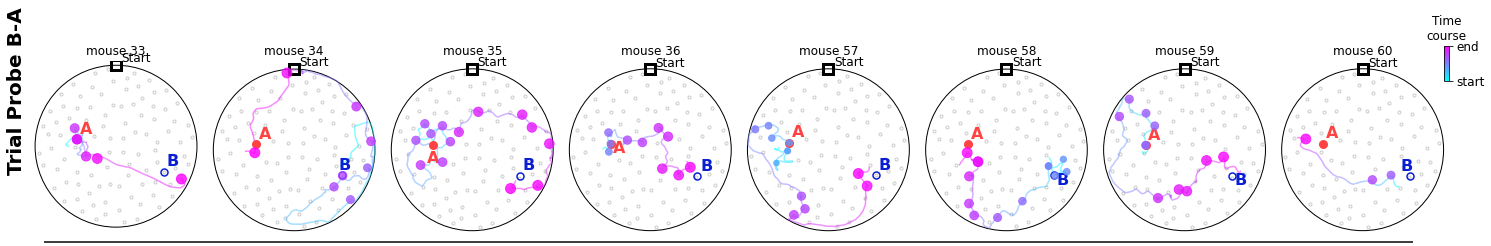

In [2]:
#import sys
#if 'modules.traj_analysis' in sys.modules.keys():
#    del sys.modules['modules.traj_analysis']
#if tran:
#    del tran
#import modules.traj_analysis as tran

#import sys
#if 'modules.plot_func' in sys.modules.keys():
#    del sys.modules['modules.plot_func']
#if pltt:
#    del pltt
#import modules.plot_func as pltt

keep_between_targets = True
stop_at_food         = True
filename_expr        = 'mpos_*Probe2_*'
mouse_traj_dir       = r'./experiments/two_target_no_cues/mouse_*'

hole_horizon          = 10.0 # cm
time_delay_after_food = 1.0 # sec

input_tracks           = io.load_trial_file(mouse_traj_dir,file_name_expr=filename_expr,align_to_top=True,fix_nan=True,sort_by_trial=True,return_group_by_keys=False,remove_after_food=False)
if keep_between_targets:
    input_tracks       = tran.keep_path_between_targets(input_tracks,return_t_in_targets=False,hole_horizon=hole_horizon,time_delay_after_food=time_delay_after_food,copy_tracks=True)
elif stop_at_food:
    input_tracks       = tran.remove_path_after_food(input_tracks,force_main_target=False,return_t_to_food=False,hole_horizon=hole_horizon,time_delay_after_food=time_delay_after_food,copy_tracks=True)

trim_trajectories  = True
traj_alpha         = 0.5

start_vec_align       = (0,1)

ignore_entrance_positions   = False
normalize_by                = 'max'
hole_horizon_hole_check     = 3.0 #cm
threshold_method            = 'ampv'
velocity_amplitude_fraction = 0.2
use_velocity_minima         = True
velocity_min_prominence     = 5.0 # cm/s

#if trim_trajectories:
#    tracks_to_plot = []
#    for tr,tr_trim in zip(all_trials_p2_complete,all_trials_p2):
#        t0 = 0.0 # seconds
#        if (int(tr.mouse_number) == 35):
#            t0 = 35.0 # the mouse doesn't move in the first 35 seconds
#        if (int(tr.mouse_number) == 34):
#            t0 = 20.0 # the mouse doesn't move in the first 35 seconds
#        tr_new = tran.slice_track_by_time(tr,t0=t0,t1=tr_trim.time[-1]+1,copy_track=True)
#        tr_new.time -= tr_new.time[0]
#        tracks_to_plot.append(tr_new)
#else:
#    tracks_to_plot = copy.deepcopy(all_trials_p2_complete)

tracks_to_plot    = list(misc.flatten_list(copy.deepcopy(input_tracks),only_lists=True))
nrows_ncols_tuple = (1,8)
first_trial=0


all_trials = plib.rotate_trial_file(tracks_to_plot,start_vec_align,True)
k_slow,t_slow,r_slow,v_th = misc.unpack_list_of_tuples([ tran.find_slowing_down_close_to_hole(tr,hole_horizon_hole_check,threshold_method=threshold_method,gamma=velocity_amplitude_fraction,
                                                                                                 return_pos_from='hole',ignore_entrance_positions=ignore_entrance_positions,
                                                                                                 use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for tr in all_trials ])


color_red    = numpy.array((255, 66, 66,255))/255
color_blue   = numpy.array(( 10, 30,211,255))/255
color_orange = pltt.get_gradient(10,'orange')[0]
ax,lines,panel_ind=pltt.plot_all_tracks_2targets(all_trials,hole_horizon,time_delay_after_food,
                                       traj1Args=dict(color                  = plt.get_cmap('cool'),
                                                      line_gradient_variable = 'time',
                                                      alpha                  = traj_alpha,
                                                      show_colorbar=False,
                                                      startArgs     = dict(marker='s',markeredgewidth=3  ,markersize=10,color='k'       ,fillstyle='none',label='Start',labelArgs=dict(fontsize=12,va='bottom',ha='left',color='k',pad=(4,0)  ) ),
                                                      targetArgs    = dict(marker='o',markeredgewidth=3  ,markersize= 6,color=color_red ,fillstyle='full',label='A'    ,labelArgs=dict(fontsize=16,va='bottom',ha='left', fontweight='bold',color=color_red ,pad=(2,2))),
                                                      targetAltArgs = dict(marker='o',markeredgewidth=1.5,markersize= 7,color=color_blue,fillstyle='none',label='B'    ,labelArgs=dict(fontsize=16,va='bottom',ha='left', fontweight='bold',color=color_blue,pad=(2,2)))),
                                       traj2Args=dict(color=(0,0,0),alpha=traj_alpha),start_align_vector=start_vec_align,
                                       trim_trajectories=False,return_panel_ind=True,show_arena_holes=True,
                                       probe_title='',fig_size=(30,22),nrows_ncols_tuple=nrows_ncols_tuple,show_probetitle=False,fix_mouse_order_in_probe=False)
text_h = [tt for tt in misc.flatten_list(lines) if (('text' in str(type(tt))) and (tt.get_text() != 'Start'))]
text_h[11].set(va='top')   # A,i=0,j=3
text_h[3].set(ha='center') # A,i=1,j=1
text_h[-3].set(va='top')   # A,i=1,j=2
text_h[-1].set(ha='right') # A,i=1,j=3
text_h[6].set(va='top')    # B,i=0,j=1
text_h[4].set(va='top',ha='center',position=numpy.array(text_h[4].get_position())-numpy.array((2,6)))    # B,i=0,j=0


ax = pltt.tight_arena_panels(ax,adjust_title_position=False,dy_amid_panels=0.02)

cax = []
for k,(ind,r,tr) in enumerate(zip(k_slow,r_slow,tracks_to_plot)):
    t_seq = tr.time[ind]/tr.time[-1]
    i,j = numpy.unravel_index(k,nrows_ncols_tuple)
    pltt.plot_trajectory_points(r,ax=ax[i,j],use_scatter=True,s=1e2*t_seq,marker='o',c=plt.get_cmap('cool')(t_seq),zorder=10000,alpha=0.8)
    if j == 0:
        ax[i,j].text(-75,-20,'Trial Probe B-A',rotation=90,va='bottom',ha='center',fontsize=20,fontweight='bold')
        x_lim = ax[i,j].get_xlim()
        y_lim = ax[i,j].get_xlim()
        lh = pltt.plot_horizontal_lines(-70,ax[i,j],xMin=-55,xMax=120*8,color='k',linewidth=1.5,linestyle='-')
        lh.set_clip_on(False)
        ax[i,j].set_xlim(x_lim)
        ax[i,j].set_ylim(y_lim)
    if j == (nrows_ncols_tuple[1]-1):
        cax.append(pltt._add_colorbar(ax[i,j],'cool',w_fraction_of_ax=0.03,h_fraction_of_ax=0.2,p0=(1.01,1.1),minmax_tick_labels=('start','end'),title='Time\ncourse',titleArgs=dict(color='k',fontsize=12),ticklabelsArgs=dict(color='k')))


if save_output_figures:
    detection_label = 'vmin' if use_velocity_minima else 'slowdown'
    plt.savefig(  f'{output_dir}/twotargets_trajectories_ALL_TRIALS_PROBE_A-B_{detection_label}.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')



plt.show()